Since diffusion-basics.ipynb became too long, starting afresh in this notebook

And trying U-net architecture again (as per Tejas' advice)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from diffusers import UNet2DModel
import matplotlib as plt

In [7]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [18]:
class DiffusionModel(nn.Module):
    def __init__(self, img_size, num_classes=10, class_emb_size=4):
        super().__init__()

        # The embedding layer will map the class label to a vector of size class_emb_size 
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        self.model = UNet2DModel(
            sample_size=img_size,            # the target image resolution
            in_channels=1 + class_emb_size,  # Additional input channels to accept the conditioning information (the class)
            out_channels=1,            # the number of output channels
            layers_per_block=2,        # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),  
            down_block_types=(
                "DownBlock2D",          # a regular ResNet downsampling block
                "AttnDownBlock2D",      # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",        # a ResNet upsampling block with spatial self-attention
                "AttnUpBlock2D",
                "UpBlock2D",            # a regular ResNet upsampling block
            ),
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, x, t, class_label):
        # Shape of x:
        bs, ch, w, h = x.shape
    
        # class conditioning is right shape to add as additional input channel
        class_cond = self.class_emb(class_label).view(bs, self.class_emb.embedding_dim, 1, 1)
        class_cond = class_cond.expand(bs, self.class_emb.embedding_dim, w, h)
        # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)
    
        # Net input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)
    
        # Feed the UNet with net_input, time step t, and return the prediction
        return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [8]:
class RescaleTransform(object):
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, tensor):
        return (self.max_val - self.min_val) * tensor + self.min_val # convert 0-1 range to -1 to +1 range

transform = transforms.Compose([
    transforms.ToTensor(),
    RescaleTransform(-1, 1)
])

trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

In [19]:
model = DiffusionModel(img_size=28, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [20]:
import random
import matplotlib.pyplot as plt

def sample_image_multiple(num_samples=1):
    with torch.no_grad():
        # Generate initial pure Gaussian noise
        x = torch.randn(num_samples, 1, 28, 28).to(device)
        y = torch.randint(0, 10, (num_samples,)).to(device)  # Generate random target labels
        
        for t in range(len(alpha_bar) - 1, -1, -1):
            z = torch.randn(num_samples, 1, 28, 28).to(device) if t > 0 else 0
            alpha_t = alpha[t]
            alpha_bar_t = alpha_bar[t]
            beta_t = beta[t]
            #alpha_t_prev = alpha_bar[t - 1] if t > 0 else 1
            
            predicted_noise = model(x, torch.tensor([t]).expand(num_samples).to(device), y)
            
            x = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * predicted_noise) + torch.sqrt(beta_t) * z
        
        generated_samples = x.cpu().squeeze().numpy()
    
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    
    for i in range(num_samples):
        if num_samples == 1:
            axs.imshow(generated_samples[i], cmap="gray")
            axs.set_title(f"Digit: {y[i].item()}")
            axs.axis("off")
        else:
            axs[i].imshow(generated_samples[i], cmap="gray")
            axs[i].set_title(f"Digit: {y[i].item()}")
            axs[i].axis("off")
    
    plt.tight_layout()
    plt.show()

num_steps = 200
beta_start = 0.0001
beta_end = 0.02
# Generate the beta values linearly from beta_start to beta_end
beta = torch.linspace(beta_start, beta_end, num_steps).to(device)
alpha = 1 - beta
# Pre-calculate alpha_bar_t for all timesteps
alpha_bar = torch.cumprod(alpha, dim=0)

In [21]:
def train():
    for epoch in range(100):
        i = 0
        for data, labels in trainloader:
            data, labels = data.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Randomly generate timesteps for each example in the batch
            t = torch.randint(0, num_steps, (data.shape[0],), device=device)
            
            # Retrieve the corresponding alpha_bar_t values for each example in the batch
            alpha_bar_t = alpha_bar[t]
            
            # Generate random noise (mean 0, sd 1) tensor with the same shape as input data
            noise = torch.randn_like(data)
            
            # Calculate the noisy data using the reparameterization trick
            noisy_data = torch.sqrt(alpha_bar_t).view(-1, 1, 1, 1) * data + torch.sqrt(1 - alpha_bar_t).view(-1, 1, 1, 1) * noise
            
            predicted_noise = model(noisy_data, t, labels)
            loss = criterion(predicted_noise, noisy_data - data)
            
            loss.backward()
            optimizer.step()
            
            if (i % 100) == 0:
                print(f"Epoch [{epoch+1}/1000], i: {i}, Loss: {loss.item():.4f}")
            
            i += 1
        
        if epoch % 5 == 0:
            sample_image_multiple(num_samples=4)

Epoch [1/1000], i: 0, Loss: 0.6406
Epoch [1/1000], i: 100, Loss: 0.0596
Epoch [1/1000], i: 200, Loss: 0.0493
Epoch [1/1000], i: 300, Loss: 0.0341
Epoch [1/1000], i: 400, Loss: 0.0342


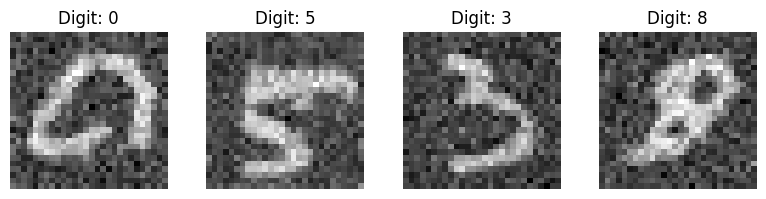

Epoch [2/1000], i: 0, Loss: 0.0374
Epoch [2/1000], i: 100, Loss: 0.0352
Epoch [2/1000], i: 200, Loss: 0.0308
Epoch [2/1000], i: 300, Loss: 0.0371
Epoch [2/1000], i: 400, Loss: 0.0339
Epoch [3/1000], i: 0, Loss: 0.0375
Epoch [3/1000], i: 100, Loss: 0.0324
Epoch [3/1000], i: 200, Loss: 0.0345
Epoch [3/1000], i: 300, Loss: 0.0356
Epoch [3/1000], i: 400, Loss: 0.0331
Epoch [4/1000], i: 0, Loss: 0.0384
Epoch [4/1000], i: 100, Loss: 0.0287
Epoch [4/1000], i: 200, Loss: 0.0365
Epoch [4/1000], i: 300, Loss: 0.0375
Epoch [4/1000], i: 400, Loss: 0.0299
Epoch [5/1000], i: 0, Loss: 0.0298
Epoch [5/1000], i: 100, Loss: 0.0332
Epoch [5/1000], i: 200, Loss: 0.0306
Epoch [5/1000], i: 300, Loss: 0.0378
Epoch [5/1000], i: 400, Loss: 0.0379
Epoch [6/1000], i: 0, Loss: 0.0366
Epoch [6/1000], i: 100, Loss: 0.0319
Epoch [6/1000], i: 200, Loss: 0.0342
Epoch [6/1000], i: 300, Loss: 0.0319
Epoch [6/1000], i: 400, Loss: 0.0369


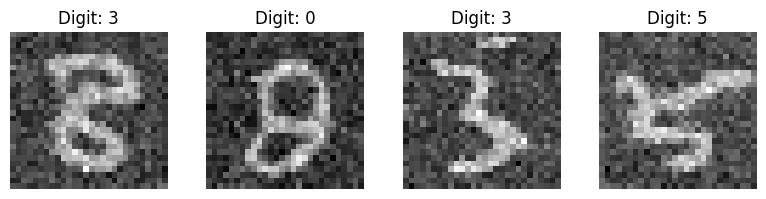

Epoch [7/1000], i: 0, Loss: 0.0318
Epoch [7/1000], i: 100, Loss: 0.0312
Epoch [7/1000], i: 200, Loss: 0.0369
Epoch [7/1000], i: 300, Loss: 0.0296
Epoch [7/1000], i: 400, Loss: 0.0338
Epoch [8/1000], i: 0, Loss: 0.0313
Epoch [8/1000], i: 100, Loss: 0.0335
Epoch [8/1000], i: 200, Loss: 0.0333
Epoch [8/1000], i: 300, Loss: 0.0299
Epoch [8/1000], i: 400, Loss: 0.0300
Epoch [9/1000], i: 0, Loss: 0.0332
Epoch [9/1000], i: 100, Loss: 0.0314
Epoch [9/1000], i: 200, Loss: 0.0329
Epoch [9/1000], i: 300, Loss: 0.0355
Epoch [9/1000], i: 400, Loss: 0.0270
Epoch [10/1000], i: 0, Loss: 0.0291
Epoch [10/1000], i: 100, Loss: 0.0300
Epoch [10/1000], i: 200, Loss: 0.0248
Epoch [10/1000], i: 300, Loss: 0.0276
Epoch [10/1000], i: 400, Loss: 0.0306
Epoch [11/1000], i: 0, Loss: 0.0310
Epoch [11/1000], i: 100, Loss: 0.0342
Epoch [11/1000], i: 200, Loss: 0.0309
Epoch [11/1000], i: 300, Loss: 0.0299
Epoch [11/1000], i: 400, Loss: 0.0300


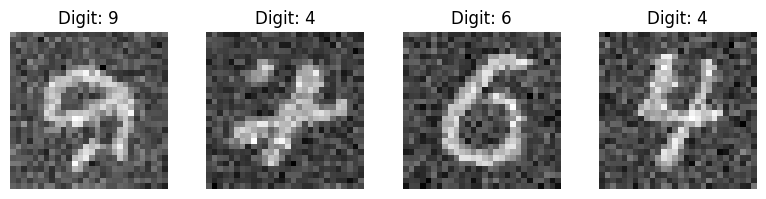

Epoch [12/1000], i: 0, Loss: 0.0355
Epoch [12/1000], i: 100, Loss: 0.0330
Epoch [12/1000], i: 200, Loss: 0.0308
Epoch [12/1000], i: 300, Loss: 0.0293
Epoch [12/1000], i: 400, Loss: 0.0304
Epoch [13/1000], i: 0, Loss: 0.0288
Epoch [13/1000], i: 100, Loss: 0.0303
Epoch [13/1000], i: 200, Loss: 0.0300
Epoch [13/1000], i: 300, Loss: 0.0320
Epoch [13/1000], i: 400, Loss: 0.0325
Epoch [14/1000], i: 0, Loss: 0.0254
Epoch [14/1000], i: 100, Loss: 0.0271
Epoch [14/1000], i: 200, Loss: 0.0272
Epoch [14/1000], i: 300, Loss: 0.0342
Epoch [14/1000], i: 400, Loss: 0.0318
Epoch [15/1000], i: 0, Loss: 0.0307
Epoch [15/1000], i: 100, Loss: 0.0312
Epoch [15/1000], i: 200, Loss: 0.0276
Epoch [15/1000], i: 300, Loss: 0.0306
Epoch [15/1000], i: 400, Loss: 0.0300
Epoch [16/1000], i: 0, Loss: 0.0352
Epoch [16/1000], i: 100, Loss: 0.0282
Epoch [16/1000], i: 200, Loss: 0.0316
Epoch [16/1000], i: 300, Loss: 0.0278
Epoch [16/1000], i: 400, Loss: 0.0264


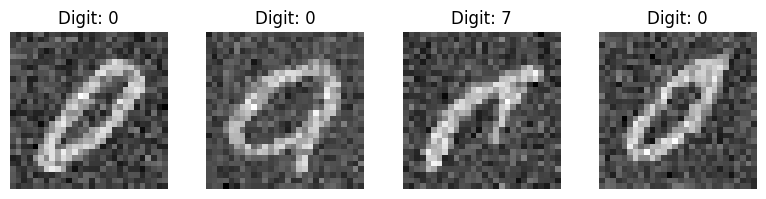

Epoch [17/1000], i: 0, Loss: 0.0302
Epoch [17/1000], i: 100, Loss: 0.0242
Epoch [17/1000], i: 200, Loss: 0.0283
Epoch [17/1000], i: 300, Loss: 0.0312
Epoch [17/1000], i: 400, Loss: 0.0286
Epoch [18/1000], i: 0, Loss: 0.0280
Epoch [18/1000], i: 100, Loss: 0.0326
Epoch [18/1000], i: 200, Loss: 0.0331
Epoch [18/1000], i: 300, Loss: 0.0259
Epoch [18/1000], i: 400, Loss: 0.0285
Epoch [19/1000], i: 0, Loss: 0.0306
Epoch [19/1000], i: 100, Loss: 0.0300
Epoch [19/1000], i: 200, Loss: 0.0295
Epoch [19/1000], i: 300, Loss: 0.0284
Epoch [19/1000], i: 400, Loss: 0.0352
Epoch [20/1000], i: 0, Loss: 0.0265
Epoch [20/1000], i: 100, Loss: 0.0295
Epoch [20/1000], i: 200, Loss: 0.0282
Epoch [20/1000], i: 300, Loss: 0.0343
Epoch [20/1000], i: 400, Loss: 0.0254
Epoch [21/1000], i: 0, Loss: 0.0295
Epoch [21/1000], i: 100, Loss: 0.0297
Epoch [21/1000], i: 200, Loss: 0.0294
Epoch [21/1000], i: 300, Loss: 0.0319
Epoch [21/1000], i: 400, Loss: 0.0299


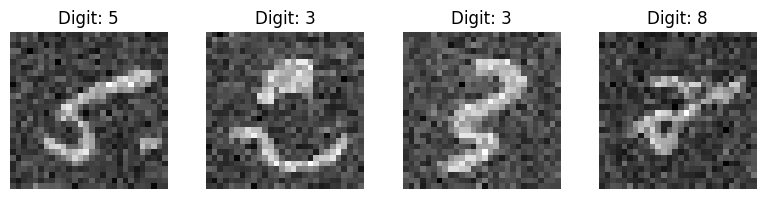

Epoch [22/1000], i: 0, Loss: 0.0290
Epoch [22/1000], i: 100, Loss: 0.0269
Epoch [22/1000], i: 200, Loss: 0.0273
Epoch [22/1000], i: 300, Loss: 0.0294
Epoch [22/1000], i: 400, Loss: 0.0308
Epoch [23/1000], i: 0, Loss: 0.0263
Epoch [23/1000], i: 100, Loss: 0.0330
Epoch [23/1000], i: 200, Loss: 0.0310
Epoch [23/1000], i: 300, Loss: 0.0283
Epoch [23/1000], i: 400, Loss: 0.0311
Epoch [24/1000], i: 0, Loss: 0.0266
Epoch [24/1000], i: 100, Loss: 0.0262
Epoch [24/1000], i: 200, Loss: 0.0245
Epoch [24/1000], i: 300, Loss: 0.0265
Epoch [24/1000], i: 400, Loss: 0.0296
Epoch [25/1000], i: 0, Loss: 0.0317
Epoch [25/1000], i: 100, Loss: 0.0312


KeyboardInterrupt: 

In [22]:
train()